In [16]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import random
import os
from PIL import Image
import numpy as np
import torch
import PIL.ImageOps
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

In [2]:
import kagglehub

vggface2_path = kagglehub.dataset_download('hearfool/vggface2')
print(vggface2_path)

100%|██████████| 2.32G/2.32G [00:10<00:00, 237MB/s]

Extracting files...


/root/.cache/kagglehub/datasets/hearfool/vggface2/versions/1


In [10]:
drive.mount('/content/drive')
madel_path = "/content/drive/My Drive/Colab Notebooks/ML/Project/final/siamese_model_v6.pth"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
    base_dir = "/root/.cache/kagglehub/datasets/hearfool/vggface2/versions/1"
    training_dir = os.path.join(base_dir, "train")
    validation_dir = os.path.join(base_dir, "val")
    train_batch_size = 64
    train_number_epochs = 100
    train_subset_size = 4000  # Increased subset size for training
    val_subset_size = 100    # Subset size for validation

In [4]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1), nn.Conv2d(1, 4, kernel_size=3), nn.ReLU(inplace=True), nn.BatchNorm2d(4),
            nn.ReflectionPad2d(1), nn.Conv2d(4, 8, kernel_size=3), nn.ReLU(inplace=True), nn.BatchNorm2d(8),
            nn.ReflectionPad2d(1), nn.Conv2d(8, 8, kernel_size=3), nn.ReLU(inplace=True), nn.BatchNorm2d(8)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(8 * 100 * 100, 500), nn.ReLU(inplace=True),
            nn.Linear(500, 500), nn.ReLU(inplace=True),
            nn.Linear(500, 128)  # Embedding dimension
        )

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2


class SiameseNetworkDataset(Dataset):
    def __init__(self, image_paths, transform=None, should_invert=True):
        self.image_paths = image_paths
        self.transform = transform
        self.should_invert = should_invert

    def __getitem__(self, index):
        img0_path, img0_label = random.choice(self.image_paths)
        should_get_same_class = random.randint(0, 1)

        if should_get_same_class:
            img1_path, img1_label = random.choice([img for img in self.image_paths if img[1] == img0_label])
        else:
            img1_path, img1_label = random.choice([img for img in self.image_paths if img[1] != img0_label])

        img0 = Image.open(img0_path).convert("L")
        img1 = Image.open(img1_path).convert("L")

        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1, torch.from_numpy(np.array([int(img1_label != img0_label)], dtype=np.float32))

    def __len__(self):
        return len(self.image_paths)

In [11]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model on the appropriate device
net = SiameseNetwork().to(device)
net.load_state_dict(torch.load(madel_path, map_location=device))
net.eval()  # Set to evaluation mode


<ipython-input-11-381effa90ea1>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(madel_path, map_location=device))


SiameseNetwork(
  (cnn1): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU(inplace=True)
    (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReflectionPad2d((1, 1, 1, 1))
    (5): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU(inplace=True)
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReflectionPad2d((1, 1, 1, 1))
    (9): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU(inplace=True)
    (11): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Sequential(
    (0): Linear(in_features=80000, out_features=500, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=500, out_features=128, bias=True)
  )
)

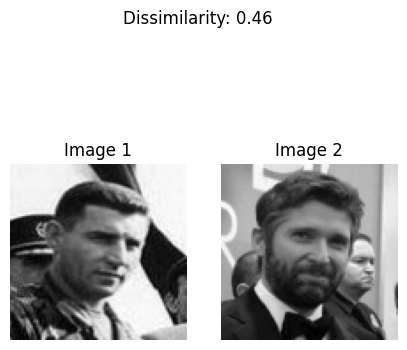

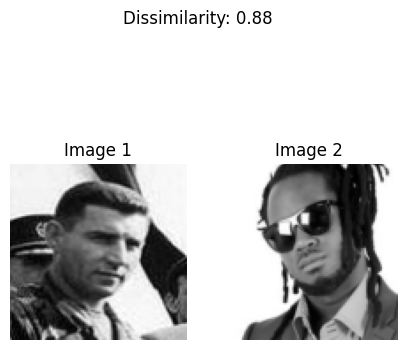

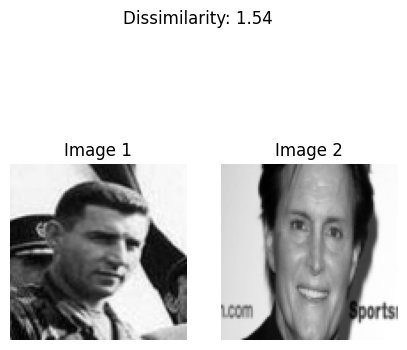

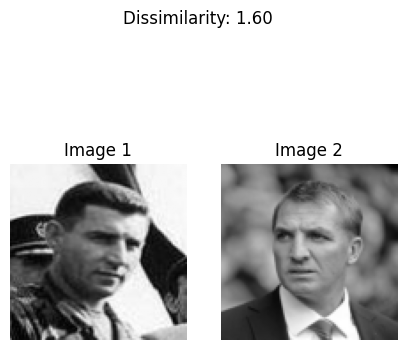

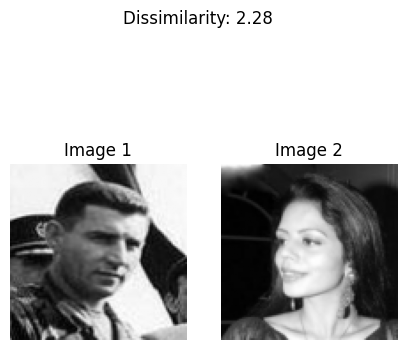

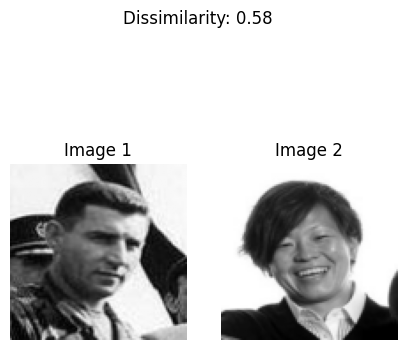

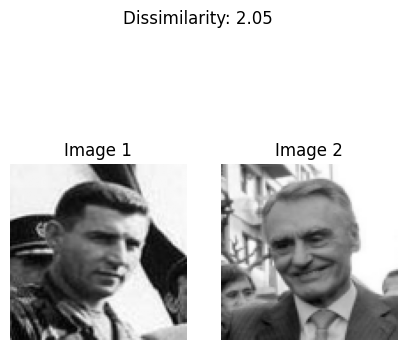

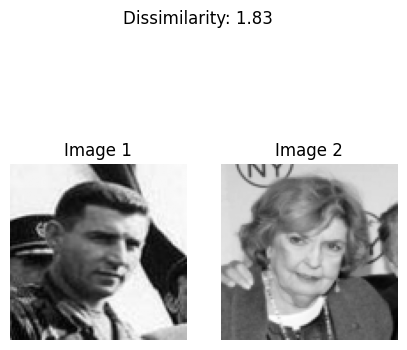

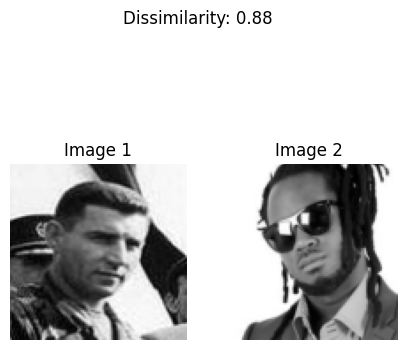

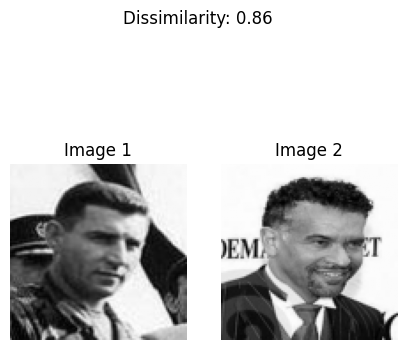

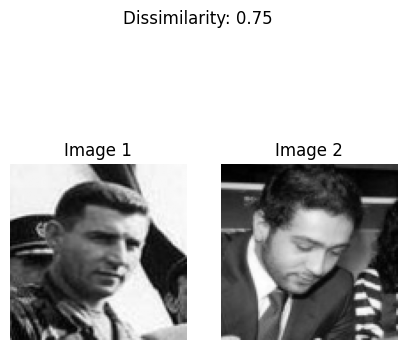

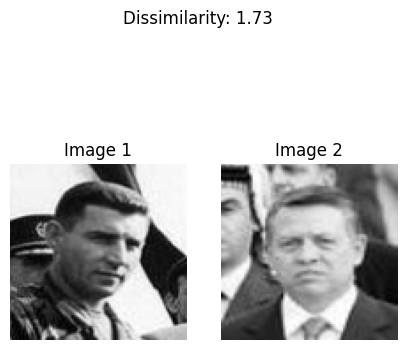

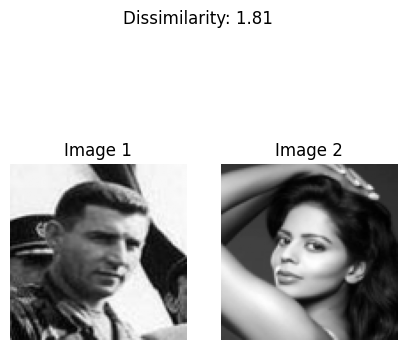

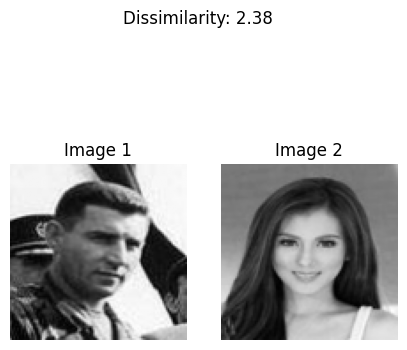

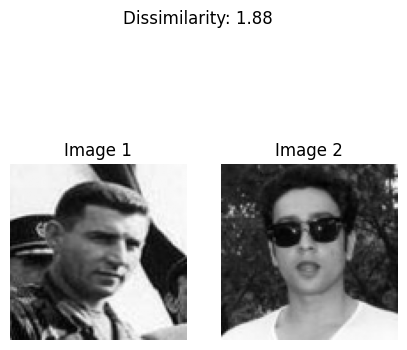

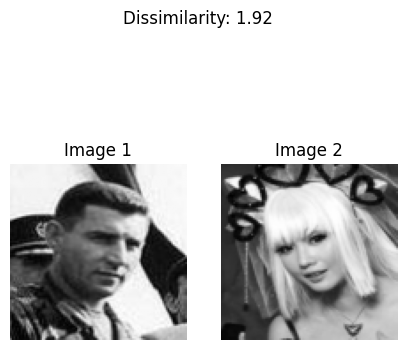

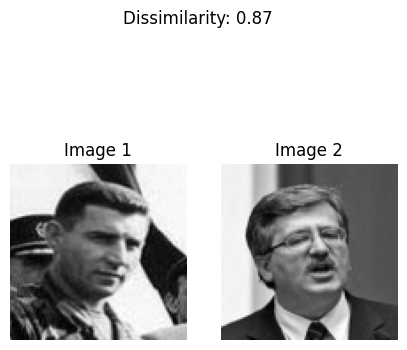

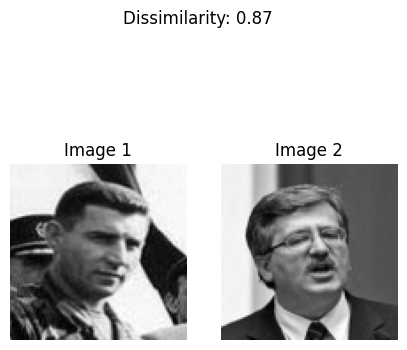

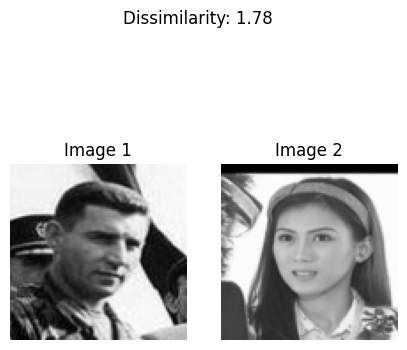

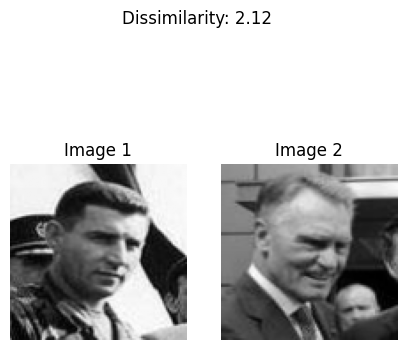

In [14]:
# Load validation dataset
folder_dataset_val = dset.ImageFolder(root=validation_dir)
val_subset_indices = random.sample(range(len(folder_dataset_val.imgs)), val_subset_size)
val_subset_paths = [folder_dataset_val.imgs[i] for i in val_subset_indices]

# Siamese Dataset for Validation
siamese_dataset_val = SiameseNetworkDataset(
    image_paths=val_subset_paths,
    transform=transforms.Compose([
        transforms.Resize((100, 100)),
        transforms.ToTensor()
    ]),
    should_invert=False
)

# DataLoader
val_dataloader = DataLoader(siamese_dataset_val, num_workers=4, batch_size=1, shuffle=True)

# Sample validation with plots
val_dataiter = iter(val_dataloader)
x0, _, _ = next(val_dataiter)

for i in range(20):
    _, x1, label2 = next(val_dataiter)

    # Move data to CPU
    output1, output2 = net(x0.to(device), x1.to(device))
    euclidean_distance = F.pairwise_distance(output1, output2)

    # Plot the images
    fig, axs = plt.subplots(1, 2, figsize=(5, 5))
    axs[0].imshow(x0.squeeze().cpu().numpy(), cmap='gray')
    axs[0].axis('off')
    axs[0].set_title('Image 1')

    axs[1].imshow(x1.squeeze().cpu().numpy(), cmap='gray')
    axs[1].axis('off')
    axs[1].set_title('Image 2')

    plt.suptitle(f'Dissimilarity: {euclidean_distance.item():.2f}')
    plt.show()


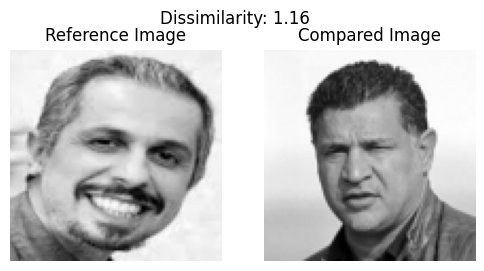

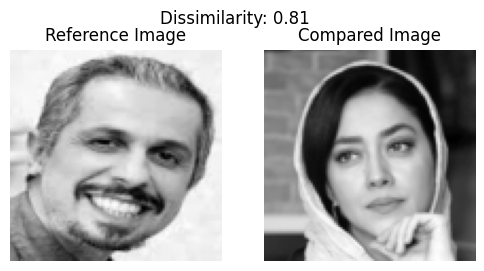

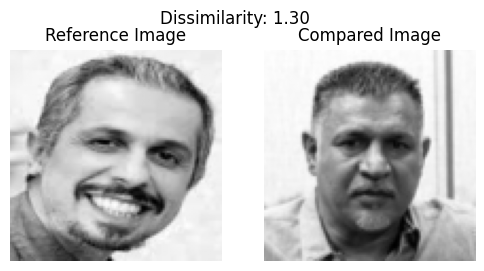

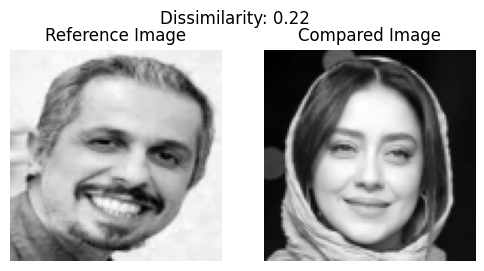

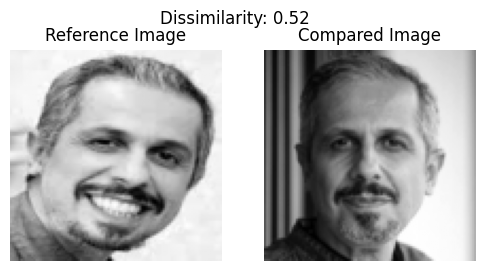

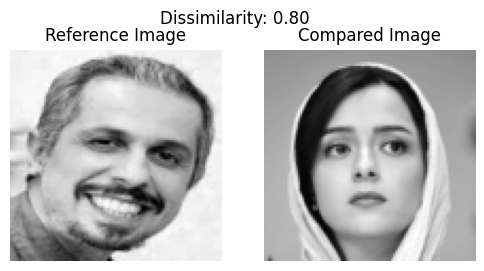

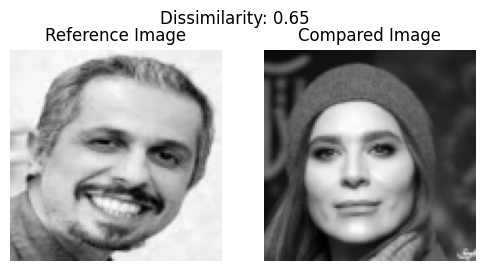

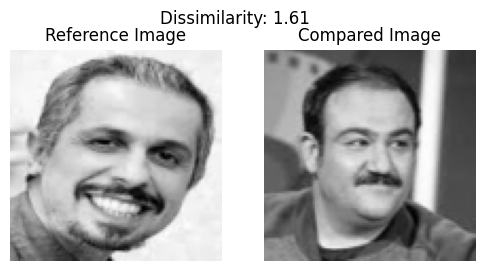

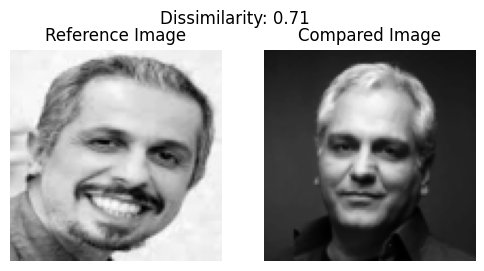

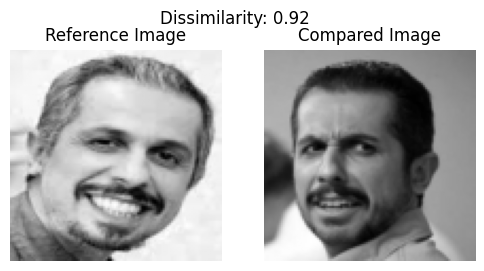

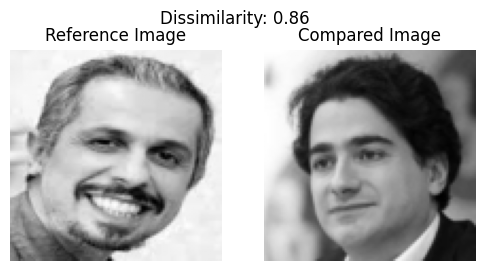

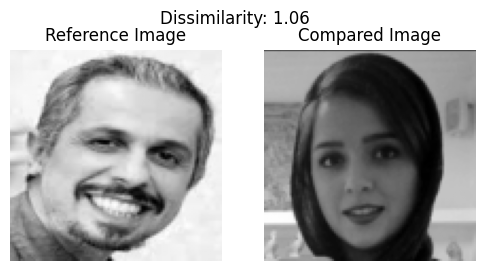

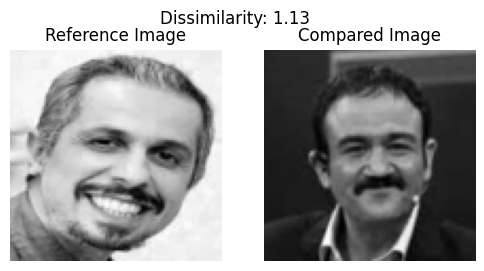

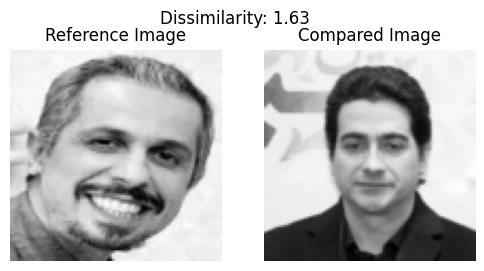

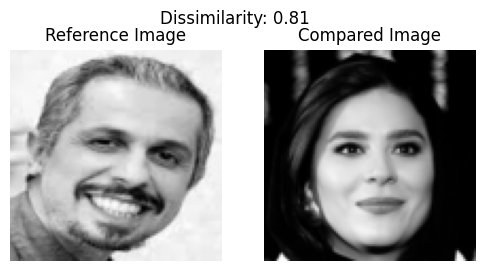

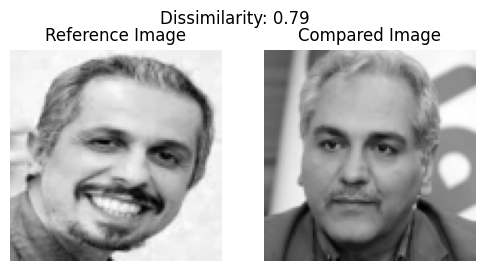

In [19]:
reference_image_path = "img.png"
test_folder_path = "/content/drive/My Drive/Colab Notebooks/ML/Project/final/test2"

# Transformations for the images (same as training)
transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor()
])

# Load the reference image
def load_image(image_path):
    img = Image.open(image_path).convert("L")  # Convert to grayscale
    img = transform(img)                      # Apply transformations
    return img.unsqueeze(0)                   # Add batch dimension

# Load test images from the folder
test_images = []
test_image_paths = []

for filename in os.listdir(test_folder_path):
    file_path = os.path.join(test_folder_path, filename)
    try:
        img = load_image(file_path)
        test_images.append(img)
        test_image_paths.append(file_path)
    except:
        print(f"Could not load image: {filename}")

# Convert reference image to tensor
x0 = load_image(reference_image_path).to(device)


# Compare the reference image to all images in the folder
for img_path, x1 in zip(test_image_paths, test_images):
    x1 = x1.to(device)
    output1, output2 = net(x0, x1)
    euclidean_distance = F.pairwise_distance(output1, output2)

    # Plot the reference and test image
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))

    axs[0].imshow(x0.squeeze().cpu().numpy(), cmap='gray')
    axs[0].axis('off')
    axs[0].set_title('Reference Image')

    axs[1].imshow(x1.squeeze().cpu().numpy(), cmap='gray')
    axs[1].axis('off')
    axs[1].set_title('Compared Image')

    plt.suptitle(f'Dissimilarity: {euclidean_distance.item():.2f}')
    plt.show()


Mehran_Ghafoorian: Average Dissimilarity = 0.76
Javad_Razavian: Average Dissimilarity = 0.74
Mehran_Modiri: Average Dissimilarity = 0.92
Homayoon_Shajarian: Average Dissimilarity = 0.94
Taraneh_Alidoosti: Average Dissimilarity = 0.94
Bahare_KianAfshar: Average Dissimilarity = 1.01
Ali_Daei: Average Dissimilarity = 0.83
Sahar_Dolatshahi: Average Dissimilarity = 1.12
Recognized Person: Javad_Razavian with dissimilarity: 0.74


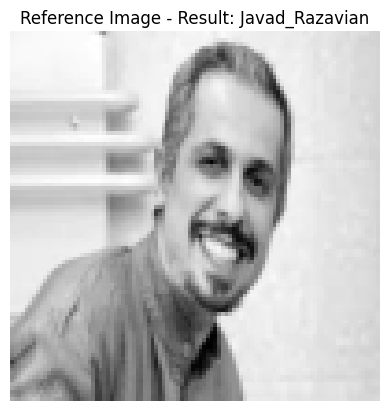

In [37]:
reference_image_path = "img.jpg"
registered_folder_path = "/content/drive/My Drive/Colab Notebooks/ML/Project/final/registered"

# Threshold for recognition
THRESHOLD = 1

# Transformations for the images (same as training)
transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor()
])

# Load an image
def load_image(image_path):
    img = Image.open(image_path).convert("L")  # Convert to grayscale
    img = transform(img)  # Apply transformations
    return img.unsqueeze(0).to(device)  # Add batch dimension & move to CPU

# Calculate average dissimilarity for a person
def calculate_average_dissimilarity(reference_img, person_folder, person_name):
    register_folder = os.path.join(person_folder, "register")
    dissimilarities = []

    for filename in os.listdir(register_folder):
        img_path = os.path.join(register_folder, filename)
        try:
            registered_img = load_image(img_path)
            output1, output2 = net(reference_img, registered_img)
            dissimilarity = F.pairwise_distance(output1, output2).item()
            dissimilarities.append(dissimilarity)
        except Exception as e:
            print(f"Could not load image: {filename}, Error: {e}")

    if dissimilarities:
        avg_dissimilarity = sum(dissimilarities) / len(dissimilarities)
        print(f"{person_name}: Average Dissimilarity = {avg_dissimilarity:.2f}")
        return avg_dissimilarity
    else:
        return float('inf')


reference_img = load_image(reference_image_path)

# Check against all registered persons
results = {}
for person in os.listdir(registered_folder_path):
    person_folder = os.path.join(registered_folder_path, person)
    if os.path.isdir(person_folder):
        avg_dissimilarity = calculate_average_dissimilarity(reference_img, person_folder, person)
        results[person] = avg_dissimilarity

# Identify the person with minimum average dissimilarity
recognized_person = min(results, key=results.get)
min_dissimilarity = results[recognized_person]

# Display the result
if min_dissimilarity < THRESHOLD:
    print(f"Recognized Person: {recognized_person} with dissimilarity: {min_dissimilarity:.2f}")
else:
    print("Person not recognized.")

# Optional: Plot the reference image
plt.imshow(reference_img.squeeze().cpu().numpy(), cmap='gray')
plt.axis('off')
plt.title(f'Reference Image - Result: {recognized_person if min_dissimilarity < THRESHOLD else "Unknown"}')
plt.show()


Mehran_Ghafoorian: Average Dissimilarity = 1.41
Javad_Razavian: Average Dissimilarity = 1.21
Mehran_Modiri: Average Dissimilarity = 1.41
Homayoon_Shajarian: Average Dissimilarity = 0.92
Taraneh_Alidoosti: Average Dissimilarity = 1.02
Bahare_KianAfshar: Average Dissimilarity = 0.74
Ali_Daei: Average Dissimilarity = 1.23
Sahar_Dolatshahi: Average Dissimilarity = 0.84
Recognized Person: Bahare_KianAfshar with dissimilarity: 0.74


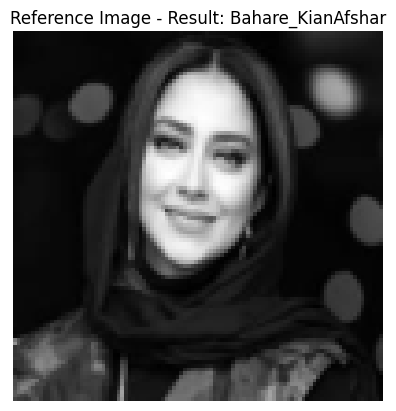

In [28]:
reference_image_path = "b.jpg"
reference_img = load_image(reference_image_path)

# Check against all registered persons
results = {}
for person in os.listdir(registered_folder_path):
    person_folder = os.path.join(registered_folder_path, person)
    if os.path.isdir(person_folder):
        avg_dissimilarity = calculate_average_dissimilarity(reference_img, person_folder, person)
        results[person] = avg_dissimilarity

# Identify the person with minimum average dissimilarity
recognized_person = min(results, key=results.get)
min_dissimilarity = results[recognized_person]

# Display the result
if min_dissimilarity < THRESHOLD:
    print(f"Recognized Person: {recognized_person} with dissimilarity: {min_dissimilarity:.2f}")
else:
    print("Person not recognized.")

# Optional: Plot the reference image
plt.imshow(reference_img.squeeze().cpu().numpy(), cmap='gray')
plt.axis('off')
plt.title(f'Reference Image - Result: {recognized_person if min_dissimilarity < THRESHOLD else "Unknown"}')
plt.show()


Mehran_Ghafoorian: Average Dissimilarity = 0.90
Javad_Razavian: Average Dissimilarity = 0.96
Mehran_Modiri: Average Dissimilarity = 1.18
Homayoon_Shajarian: Average Dissimilarity = 0.61
Taraneh_Alidoosti: Average Dissimilarity = 0.86
Bahare_KianAfshar: Average Dissimilarity = 0.94
Ali_Daei: Average Dissimilarity = 0.69
Sahar_Dolatshahi: Average Dissimilarity = 0.96
Recognized Person: Homayoon_Shajarian with dissimilarity: 0.61


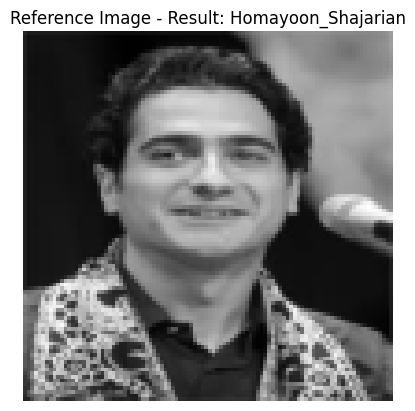

In [33]:
reference_image_path = "hm4.jpg"
reference_img = load_image(reference_image_path)

# Check against all registered persons
results = {}
for person in os.listdir(registered_folder_path):
    person_folder = os.path.join(registered_folder_path, person)
    if os.path.isdir(person_folder):
        avg_dissimilarity = calculate_average_dissimilarity(reference_img, person_folder, person)
        results[person] = avg_dissimilarity

# Identify the person with minimum average dissimilarity
recognized_person = min(results, key=results.get)
min_dissimilarity = results[recognized_person]

# Display the result
if min_dissimilarity < THRESHOLD:
    print(f"Recognized Person: {recognized_person} with dissimilarity: {min_dissimilarity:.2f}")
else:
    print("Person not recognized.")

# Optional: Plot the reference image
plt.imshow(reference_img.squeeze().cpu().numpy(), cmap='gray')
plt.axis('off')
plt.title(f'Reference Image - Result: {recognized_person if min_dissimilarity < THRESHOLD else "Unknown"}')
plt.show()


Mehran_Ghafoorian: Average Dissimilarity = 1.04
Javad_Razavian: Average Dissimilarity = 1.24
Mehran_Modiri: Average Dissimilarity = 1.09
Homayoon_Shajarian: Average Dissimilarity = 1.74
Taraneh_Alidoosti: Average Dissimilarity = 1.47
Bahare_KianAfshar: Average Dissimilarity = 1.63
Ali_Daei: Average Dissimilarity = 1.41
Sahar_Dolatshahi: Average Dissimilarity = 1.78
Person not recognized.


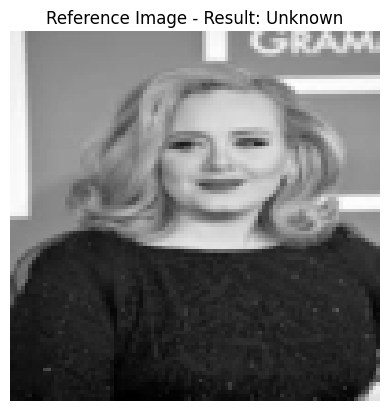

In [38]:
reference_image_path = "a.jpg"
reference_img = load_image(reference_image_path)

# Check against all registered persons
results = {}
for person in os.listdir(registered_folder_path):
    person_folder = os.path.join(registered_folder_path, person)
    if os.path.isdir(person_folder):
        avg_dissimilarity = calculate_average_dissimilarity(reference_img, person_folder, person)
        results[person] = avg_dissimilarity

# Identify the person with minimum average dissimilarity
recognized_person = min(results, key=results.get)
min_dissimilarity = results[recognized_person]

# Display the result
if min_dissimilarity < THRESHOLD:
    print(f"Recognized Person: {recognized_person} with dissimilarity: {min_dissimilarity:.2f}")
else:
    print("Person not recognized.")

# Optional: Plot the reference image
plt.imshow(reference_img.squeeze().cpu().numpy(), cmap='gray')
plt.axis('off')
plt.title(f'Reference Image - Result: {recognized_person if min_dissimilarity < THRESHOLD else "Unknown"}')
plt.show()


Mehran_Ghafoorian: Average Dissimilarity = 1.42
Javad_Razavian: Average Dissimilarity = 1.24
Mehran_Modiri: Average Dissimilarity = 1.45
Homayoon_Shajarian: Average Dissimilarity = 0.86
Taraneh_Alidoosti: Average Dissimilarity = 1.00
Bahare_KianAfshar: Average Dissimilarity = 0.71
Ali_Daei: Average Dissimilarity = 1.22
Sahar_Dolatshahi: Average Dissimilarity = 0.75
Recognized Person: Bahare_KianAfshar with dissimilarity: 0.71


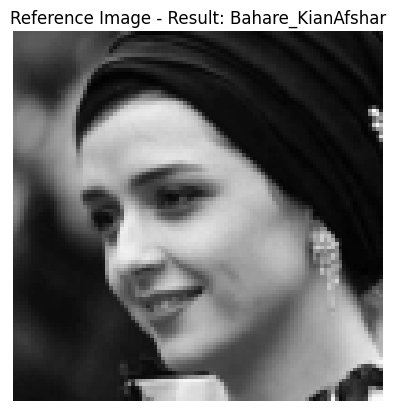

In [36]:
reference_image_path = "1.jpg"
reference_img = load_image(reference_image_path)

# Check against all registered persons
results = {}
for person in os.listdir(registered_folder_path):
    person_folder = os.path.join(registered_folder_path, person)
    if os.path.isdir(person_folder):
        avg_dissimilarity = calculate_average_dissimilarity(reference_img, person_folder, person)
        results[person] = avg_dissimilarity

# Identify the person with minimum average dissimilarity
recognized_person = min(results, key=results.get)
min_dissimilarity = results[recognized_person]

# Display the result
if min_dissimilarity < THRESHOLD:
    print(f"Recognized Person: {recognized_person} with dissimilarity: {min_dissimilarity:.2f}")
else:
    print("Person not recognized.")

# Optional: Plot the reference image
plt.imshow(reference_img.squeeze().cpu().numpy(), cmap='gray')
plt.axis('off')
plt.title(f'Reference Image - Result: {recognized_person if min_dissimilarity < THRESHOLD else "Unknown"}')
plt.show()
